In [1]:
from pathlib import Path
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
PROJECT_ROOT = Path(globals()['_dh'][0]).parent.parent

In [3]:
benchmark_arch_directories = list((PROJECT_ROOT / ".benchmarks").iterdir())
if len(benchmark_arch_directories) != 1:
    raise Exception(f"Expected exactly one benchmark architecture directory, found {len(benchmark_arch_directories)}")
benchmark_arch_directory = benchmark_arch_directories[0]
benchmark_result_paths = sorted(path for path in benchmark_arch_directory.iterdir() if path.name.endswith(".json"))
latest_benchmark_result_path = benchmark_result_paths[-1]

In [4]:
benchmarks_sorted_by_execution_time = sorted(
    json.loads(latest_benchmark_result_path.read_text())["benchmarks"],
    key=lambda benchmark: benchmark["stats"]["mean"],
)
benchmarks_by_library = {}
for benchmark in benchmarks_sorted_by_execution_time:
    meta = benchmark["extra_info"]
    library_name = meta["library_name"]
    library_benchmarks = benchmarks_by_library.setdefault(library_name, {})
    benchmark_name = meta["benchmark_name"]
    library_benchmarks[benchmark_name] = benchmark["stats"]

In [5]:
benchmark_stats = {
    benchmark["extra_info"]["library_name"]: benchmark["stats"]
    for benchmark in benchmarks_sorted_by_execution_time
}
rounds = next(iter(benchmark_stats.values()))["rounds"]
for library, stats in benchmark_stats.items():
    if stats["rounds"] != rounds:
        raise Exception(f"Expected all libraries to have {rounds} rounds, but {library} has {stats['rounds']}")

In [6]:
BARS_SIMPLE_COLOR = "#38b580"
BARS_ADVANCED_COLOR = "#68c49d"

LOG_SCALE = False

x = list(benchmarks_by_library.keys())
y_simple = [benchmarks["Simple"]["mean"] for benchmarks in benchmarks_by_library.values()]
y_simple_stddev = [benchmarks["Simple"]["stddev"] for benchmarks in benchmarks_by_library.values()]
y_advanced = [benchmarks["Advanced"]["mean"] for benchmarks in benchmarks_by_library.values()]
y_advanced_stddev = [benchmarks["Advanced"]["stddev"] for benchmarks in benchmarks_by_library.values()]


def create_barplot(log_scale: bool, y, y_stddev, title: str):
    fig, ax = plt.subplots(figsize=(6, 5), dpi=250)
    ind = np.arange(len(x))
    bar_width = 0.6
    bars_simple = ax.bar(ind, y, bar_width, yerr=y_stddev, color=BARS_SIMPLE_COLOR)
    # bars_advanced = ax.bar(ind+bar_width, y_advanced, bar_width, yerr=y_advanced_stddev, color=BARS_ADVANCED_COLOR)
    ax.set_ylabel("Execution time (s)")

    if log_scale:
        plt.yscale("log")
        ax.set_yticks([0.045, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6])
        ax.set_ylim(bottom=0)

    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.1f'))
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(ind)
    ax.set_xticklabels(x, ha="center")

    plt.suptitle(title, fontsize=16)
    plt.title(f"Mean of {rounds} rounds with standard deviation error{' (log scale)' if log_scale else ''}", fontsize=9)

    ax.grid(False)

    def add_bar_labels(ax, bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, -13 if log_scale else (-10 if height < 0.1 else -13)),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=8,
                color="white",
            )

    add_bar_labels(ax, bars_simple)
    # add_bar_labels(ax, bars_advanced)

    return plt


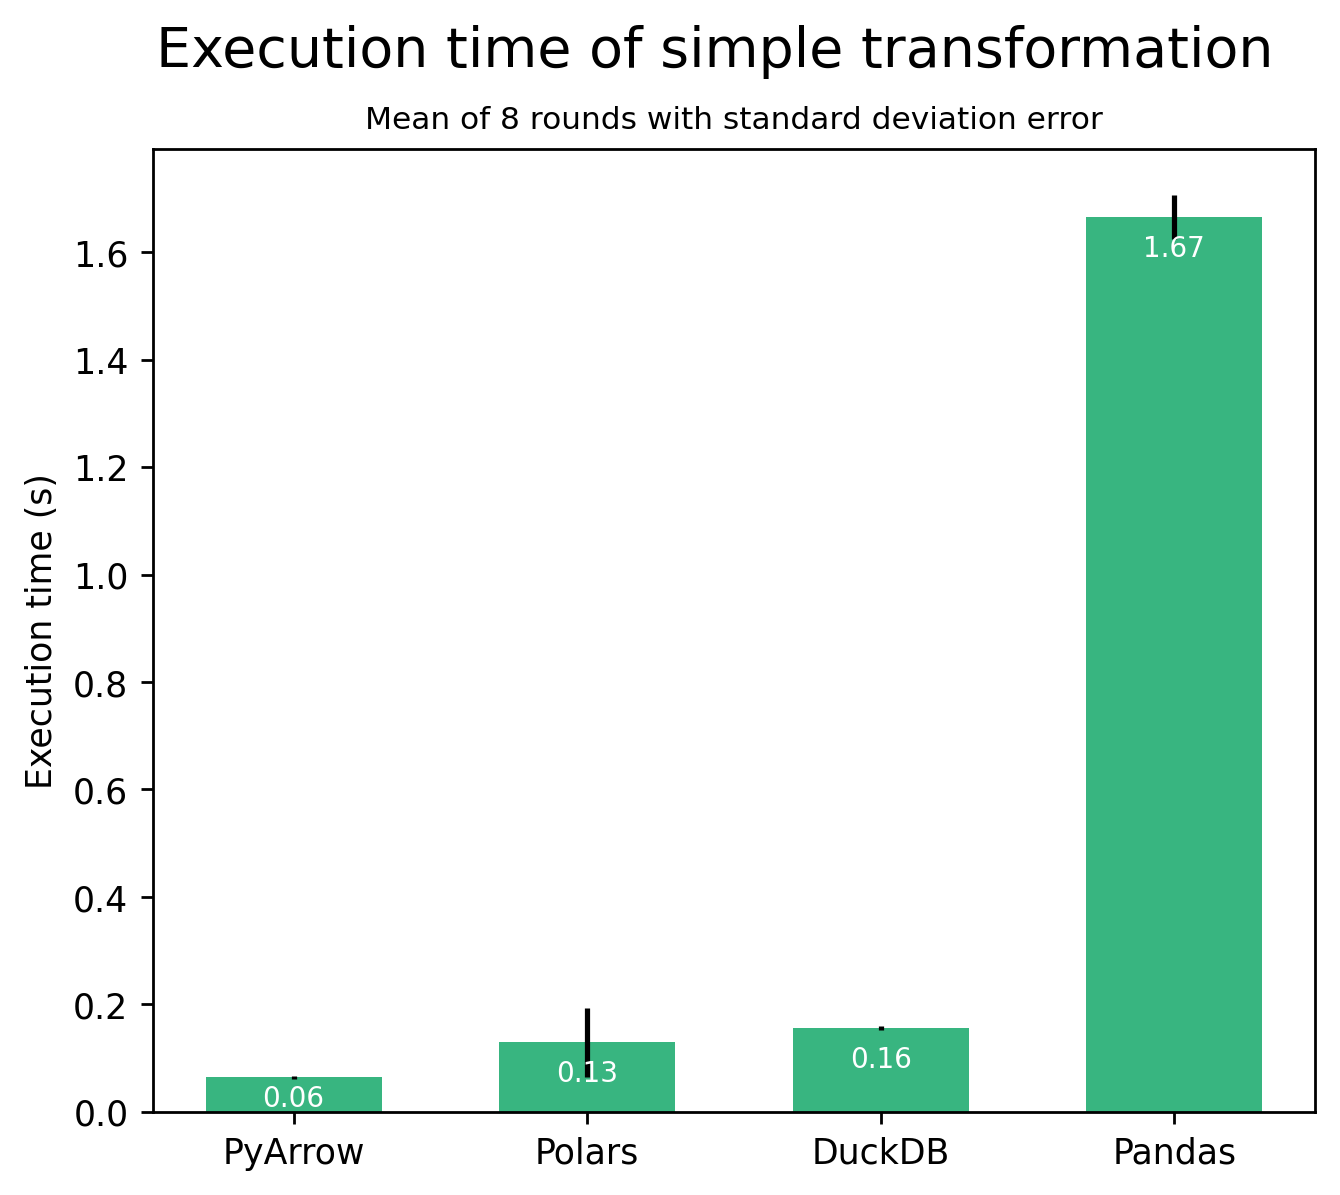

In [7]:
create_barplot(
    log_scale=False,
    y=y_simple,
    y_stddev=y_simple_stddev,
    title="Execution time of simple transformation",
).show()

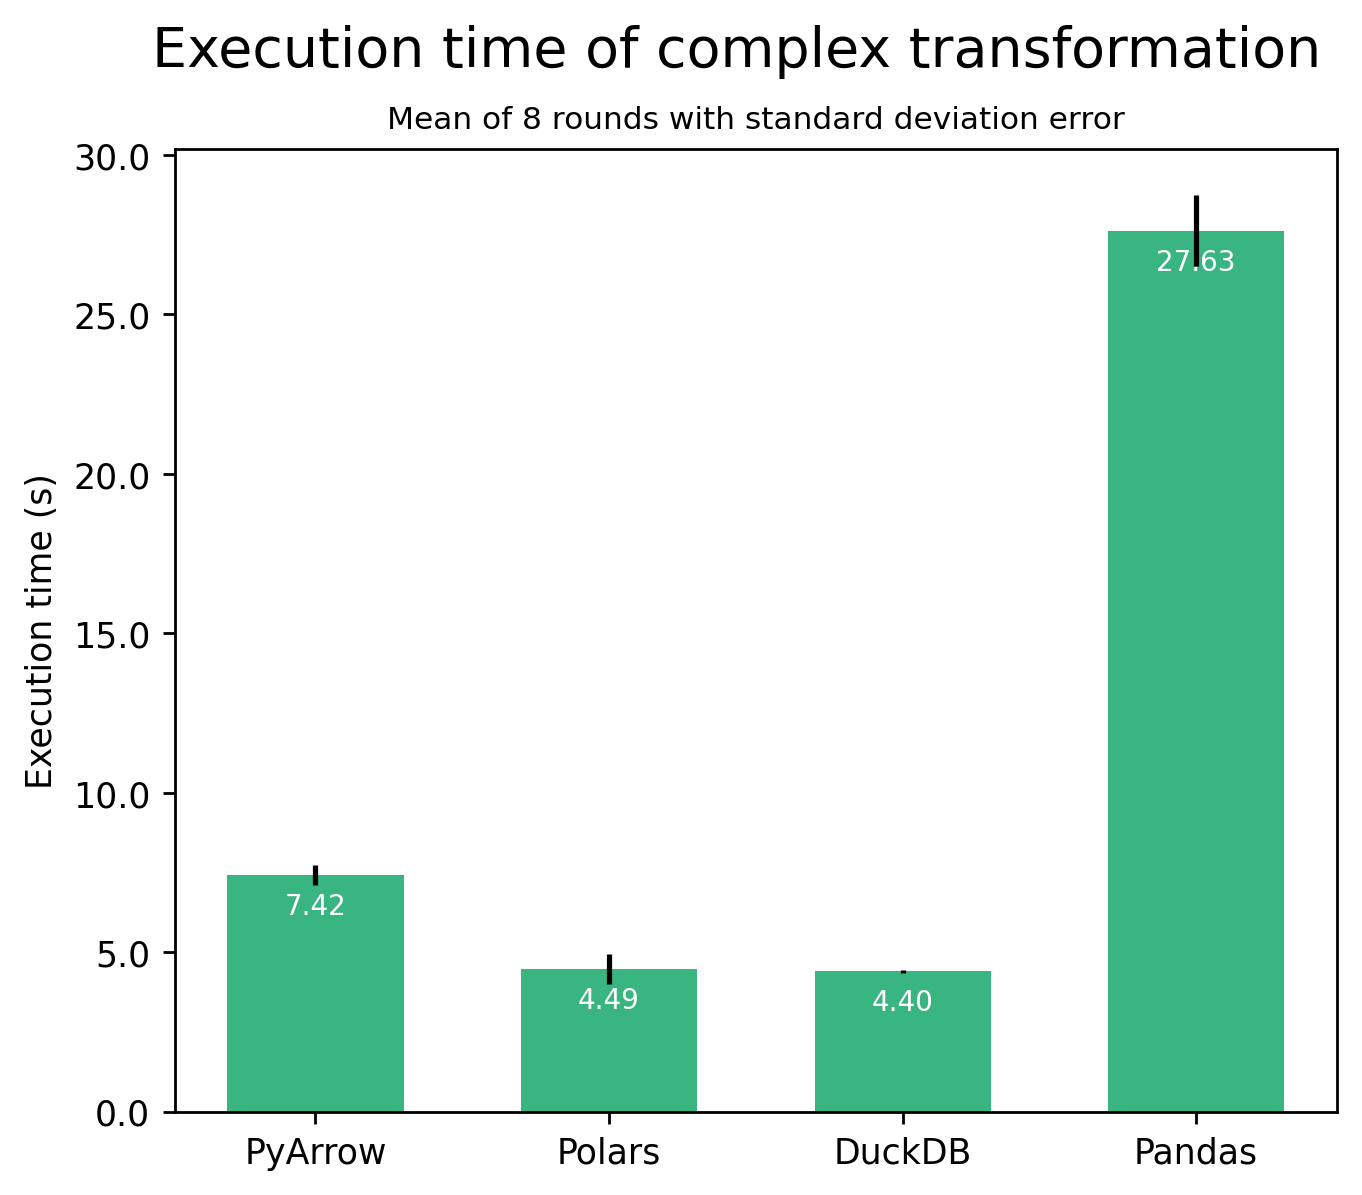

In [8]:
create_barplot(
    log_scale=False,
    y=y_advanced,
    y_stddev=y_advanced_stddev,
    title="Execution time of complex transformation",
).show()